## Описание и задачи исследования

# Цель исследования

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Необходимо провести анализ и подготовить план действий по удержанию клиентов.  

# Описание данных

Файл `gym_churn.csv`:

Столбцы:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
`Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

Из данной информации следует, что сеть собирает данные об оттоке клиентов ежемесячно.

# Источник данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

# Задачи исследования

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

# Открытие данных

Импортируем все необходимые нам библиотеки и настройки `Pandas` для отображения данных при выводе:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
#округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["axes.formatter.limits"] = (-99, 99) #disable scientific notation on axes
plt.rcParams["figure.figsize"] = (18, 10)

In [2]:
path = '/datasets/'
web_path = '****'
data = 'gym_churn.csv'

try:
    raw_df = pd.read_csv(path + data)
except:
    raw_df = pd.read_csv(web_path + data)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
raw_df.sample(15)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
920,1,1,1,1,1,12,1,33,241.44,11.00,7,2.62,2.47,0
153,1,1,0,0,1,1,0,31,329.55,1.00,1,2.66,2.71,0
670,1,1,1,1,1,6,1,28,270.40,6.00,4,1.58,1.54,0
3287,1,0,1,0,1,1,0,32,113.90,1.00,8,1.75,1.82,0
1824,0,1,0,0,1,1,1,27,69.35,1.00,4,2.10,2.18,0
571,1,1,0,0,1,1,0,33,37.84,1.00,2,0.92,0.89,0
1922,1,1,0,0,0,12,0,31,201.94,11.00,2,1.19,1.17,0
494,1,1,0,0,1,6,1,33,40.01,6.00,2,1.36,1.34,0
3616,0,0,1,0,1,6,0,30,24.62,5.00,2,0.00,0.00,0
3916,1,1,0,1,1,1,1,28,65.55,1.00,0,2.08,2.22,0


Предварительно можно сказать, что следуют привести столбец `Month_to_end_contract` к `int64`, т.к. в нем, согласно описанию, содержится информаци об оставших месяцах до окончания абонемента в целочисленном формате,  помимо этого, очень желательно привести названия столбцов  к «змеиному регистру». Из положительных моментов - в данных отсутсвуют пропуски и большинство признаков приведены к числовому типу, а самое главное - данного объема достаточно для проведения ML-исследования.

## Предобработка данных и исследовательский анализ данных (EDA)

Проведем стандартную предобработку, включающаю проверку явных дубликатов, нулевых и пропущенных значений, а также изменим тип данных и преобразуем категориальные переменные.

Проверим данные на наличие аномалий.

Приведем возможные причины, догадки и аргументы касательно заполнения или удаления значений.

In [5]:
df = raw_df.copy()

### Преобразование названий столбцов

In [6]:
df.columns = df.columns.str.lower()

### Преобразование типов данных

In [7]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [9]:
df.sample(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1068,0,1,0,0,1,1,1,29,272.23,1,2,1.23,0.28,1
831,0,1,1,1,0,12,1,26,26.84,12,5,0.22,0.29,0
2894,0,1,0,0,0,1,0,26,94.79,1,0,1.29,1.61,1
1116,0,0,0,0,1,1,0,29,133.54,1,2,1.92,1.53,1
2009,0,0,1,0,1,12,0,26,135.25,12,5,0.00,0.00,0


### Обработка дубликатов

In [10]:
print(f"Количество явных дубликатов: {df.duplicated().sum()}. Доля: {df.duplicated().sum()/df.shape[0]:.3%}.")

Количество явных дубликатов: 0. Доля: 0.000%.


### Обработка пропущенных значений


In [11]:
pd.concat([df.isna().sum(), df.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
gender,0,0.00%
near_location,0,0.00%
partner,0,0.00%
promo_friends,0,0.00%
phone,0,0.00%
contract_period,0,0.00%
group_visits,0,0.00%
age,0,0.00%
avg_additional_charges_total,0,0.00%
month_to_end_contract,0,0.00%


Как и ранее было сказано, пропуски отсутсвуют.

### Обработка нулевых значений

Создадим таблицы с указанием доли нулевых значений по каждой колонке.

In [12]:
pd.concat([df.eq(0).sum(), df.eq(0).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
gender,1959,48.98%
near_location,619,15.47%
partner,2053,51.32%
promo_friends,2766,69.15%
phone,386,9.65%
contract_period,0,0.00%
group_visits,2351,58.77%
age,0,0.00%
avg_additional_charges_total,0,0.00%
month_to_end_contract,0,0.00%


Данные имеют немало нулевых значений, но в рамках данного проекта это нормально, т.к. пропуски отсутствуют, а многие признаки имеют числовой вид.

Более подробно мы разберем каждую категорию из этого датафрейма в следующем шаге.

### Анализ данных на наличие аномальных значений

Проведем корреляционный анализ, используя функцию `describe`.

In [13]:
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


In [14]:
df['month_to_end_contract'].unique()

array([ 5, 12,  1,  6,  3, 10, 11,  9,  4,  7,  8,  2])

In [15]:
df['contract_period'].unique()

array([ 6, 12,  1])

In [16]:
df[df['churn'] == 0].describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
gender,"2,939.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"2,939.00",0.87,0.33,0.00,1.00,1.00,1.00,1.00
partner,"2,939.00",0.53,0.50,0.00,0.00,1.00,1.00,1.00
promo_friends,"2,939.00",0.35,0.48,0.00,0.00,0.00,1.00,1.00
phone,"2,939.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"2,939.00",5.75,4.72,1.00,1.00,6.00,12.00,12.00
group_visits,"2,939.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00
age,"2,939.00",29.98,3.01,19.00,28.00,30.00,32.00,41.00
avg_additional_charges_total,"2,939.00",158.45,99.80,0.17,76.92,149.88,224.45,552.59
month_to_end_contract,"2,939.00",5.28,4.36,1.00,1.00,6.00,10.00,12.00


In [17]:
df[df['churn'] == 1].describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
gender,"1,061.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"1,061.00",0.77,0.42,0.00,1.00,1.00,1.00,1.00
partner,"1,061.00",0.36,0.48,0.00,0.00,0.00,1.00,1.00
promo_friends,"1,061.00",0.18,0.39,0.00,0.00,0.00,0.00,1.00
phone,"1,061.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"1,061.00",1.73,2.13,1.00,1.00,1.00,1.00,12.00
group_visits,"1,061.00",0.27,0.44,0.00,0.00,0.00,1.00,1.00
age,"1,061.00",26.99,2.90,18.00,25.00,27.00,29.00,38.00
avg_additional_charges_total,"1,061.00",115.08,77.70,0.15,50.63,103.81,165.62,425.54
month_to_end_contract,"1,061.00",1.66,1.96,1.00,1.00,1.00,1.00,12.00


Построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака.

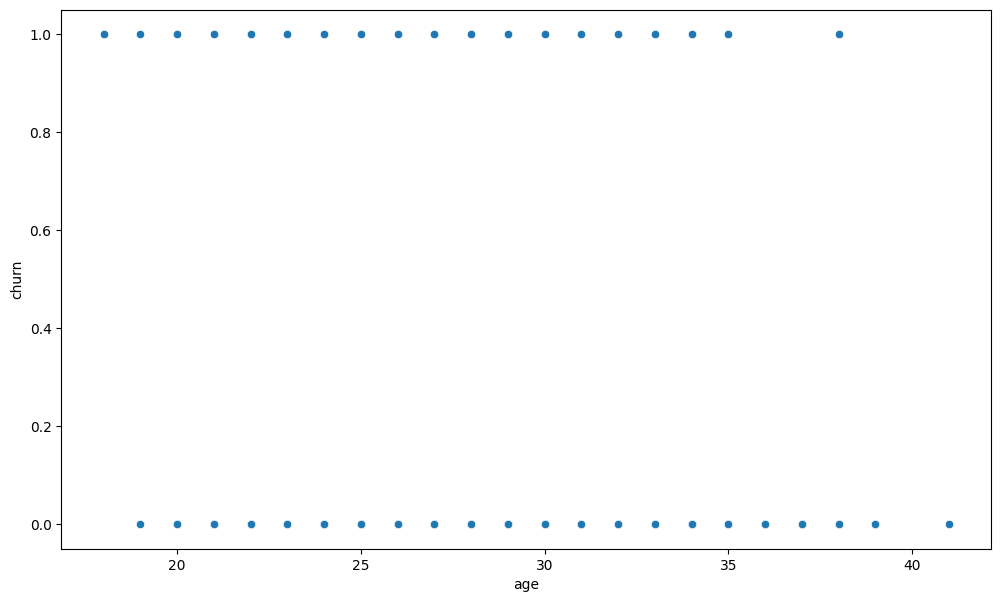

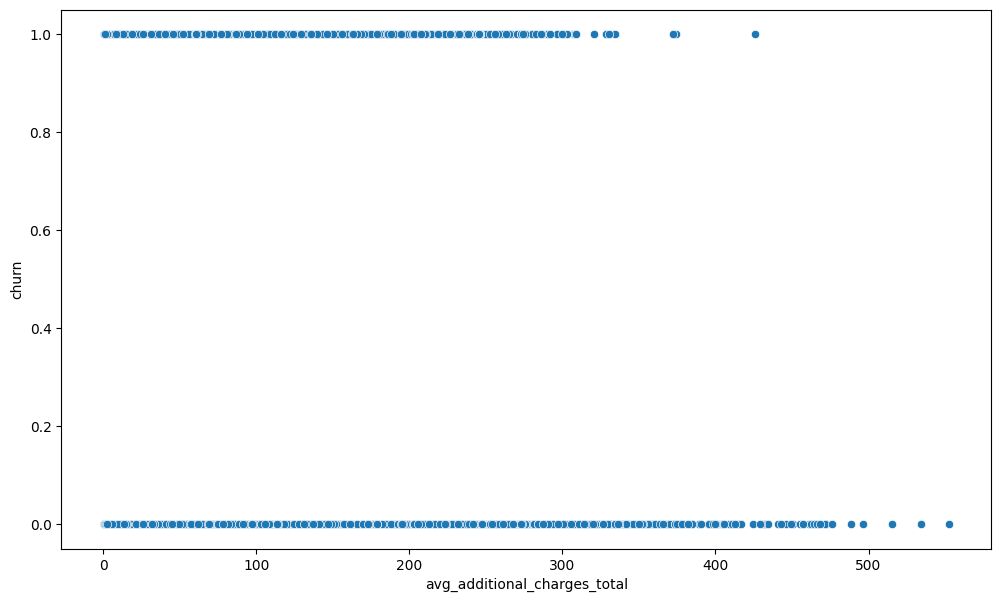

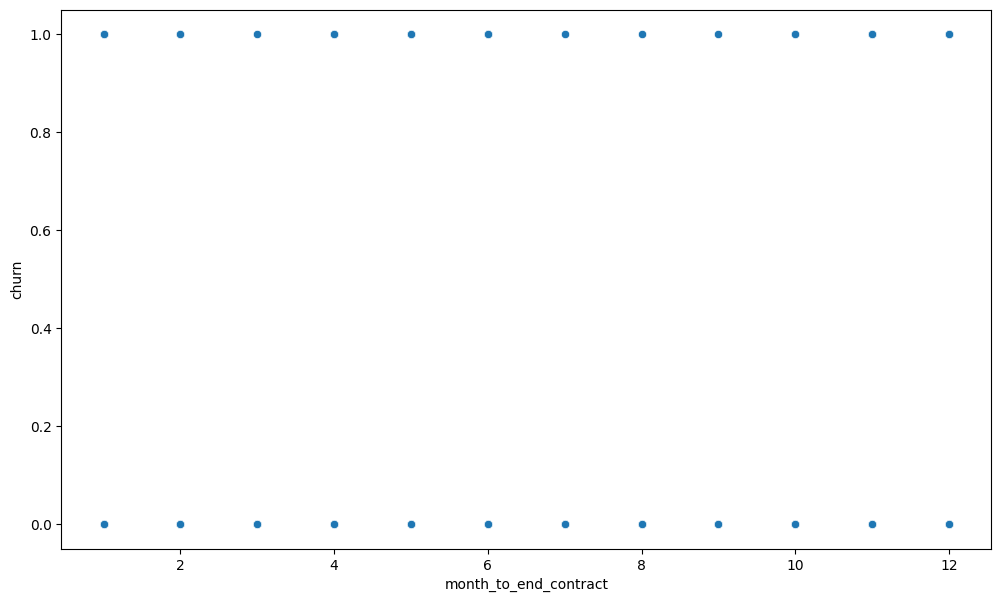

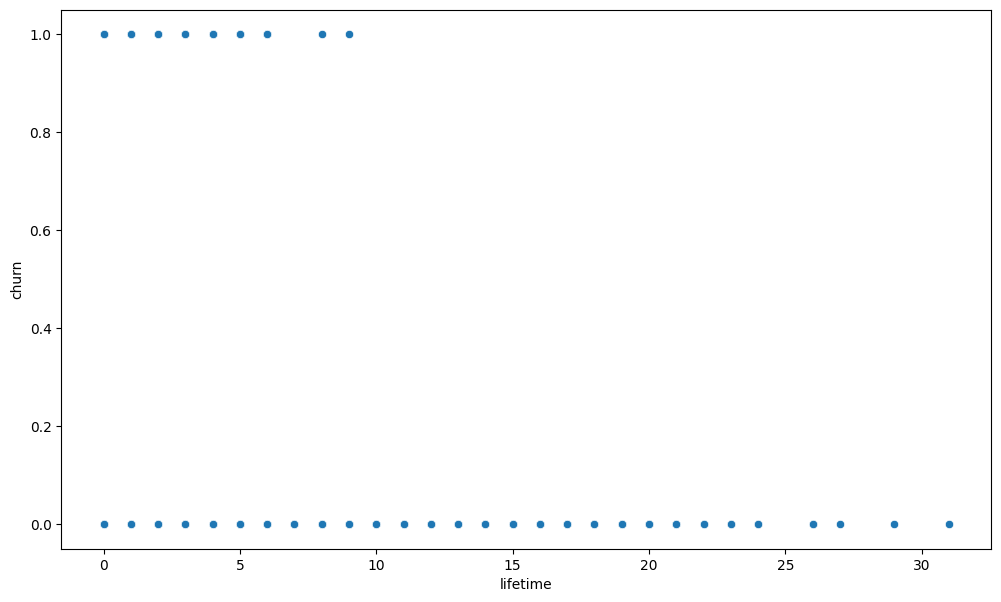

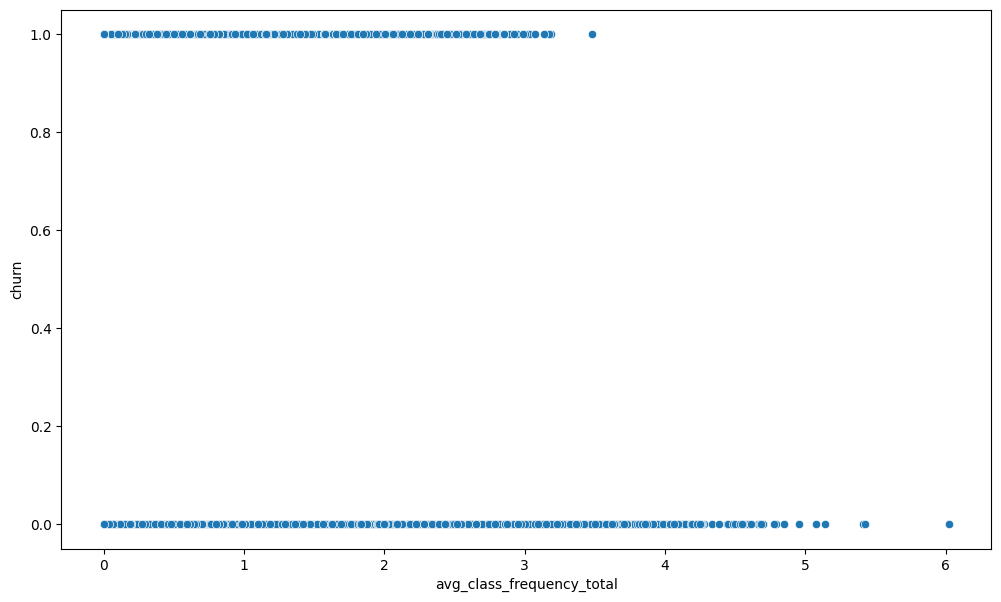

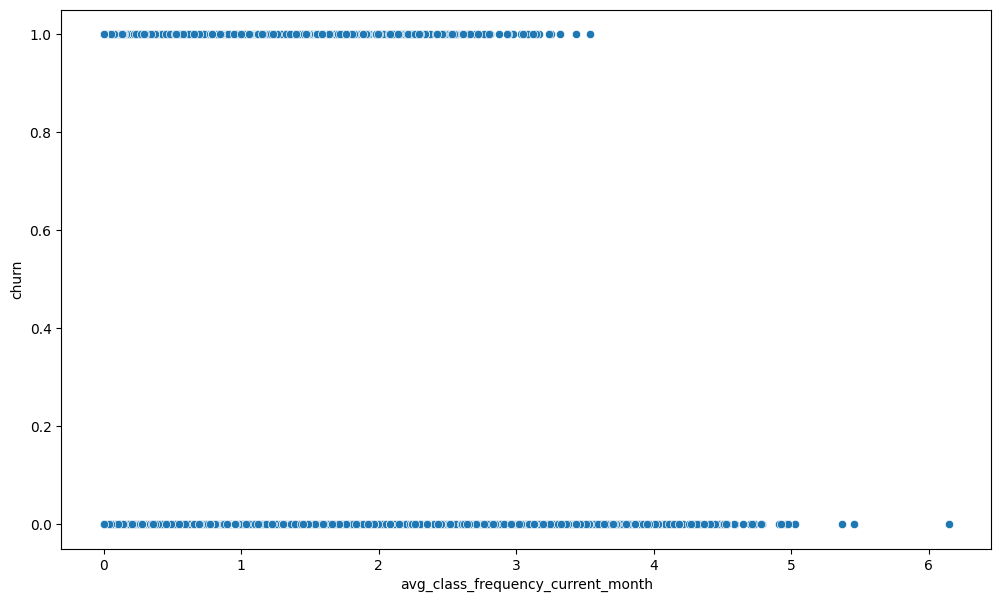

In [18]:
for col in df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6, 13]], axis = 1).columns:
    plt.figure(figsize=(12,7))
    sns.scatterplot(x=df[col], y=df['churn'])
    plt.show()

Каких-то ярких выбросов и перекосов по диаграммам рассеяния не наблюдается. Это отлично. Значит, на этих данных можно строить модель.Что касается корреляций и попарных графиков — мы уже можем заметить, что половина признаков достаточно сильно коррелирует с целевой переменной. Скорее всего, чем дольше и чем чаще клиент ходит в фитнес-клеб, тем реже он попадает в  группу оттока.

Аномалий не обнаружено.

Для дальнейшего анализа визуализируем каждый признак со значением 1 (**True**):

In [19]:
pd.concat([df.eq(1).sum(), df.eq(1).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
gender,2041,51.02%
near_location,3381,84.52%
partner,1947,48.68%
promo_friends,1234,30.85%
phone,3614,90.35%
contract_period,2207,55.17%
group_visits,1649,41.23%
age,0,0.00%
avg_additional_charges_total,0,0.00%
month_to_end_contract,2207,55.17%


Благодаря данной предыдущим таблицам можно сделать следующие выводы:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — к сожалению, у нас нет более подробной расшивроки о данной колонки, но соотношение полов примерно одинаковое, можно предположить, что скорее всего мужчин больше - **51,02%**;
* `near_location` — примерно **84.52%** пользователей проживают или работют в районе, где находится фитнес-центр;
* `partner` — **49%** пользователей составляют сотрудники компаний-партнёров клуба;
* `promo_friends` — **69.15%** пользователей приобрели абонемент самостоятельно - вне реферальной системы, т.е. лишь **30.85%**  приобрели абонементы в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента). Однако, неизвестно суммируются ли скидки с `partner`, ибо в таком случае реальный процент может измениться в обе стороны;
* `phone` — **90.35%** профилей пользователей имеют контактный телефон. Это одназначно плюс, потому что таким способом можно делать разнообразные рассылки и обзвоны;
* `age` — средний возраст клиентов составляет **27 лет**, а возрастная группа колеблется от 18 лет до 41 года;
* `lifetime` — средний период посещения фитнес-центра составляет почти **4 месяца**.

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `contract_period` — средняя длительность текущего действующего абонемента составляет почти **5 месяцев**, однако стоит учесть, что абонементы продлеваются на месяц, 6 месяцев или год, поэтому данная информация некорректна, да и стандартное отклонение это доказывает. Если говорить объективно, то подавляющие большинство клиентов приборетает абонементы на **6 месяцев**, т.е. полгода. Можно предположить, что данный выбор сделан за счет ценообразования;
* `month_to_end_contract` — средний срок до окончания текущего действующего абонемента составляет **4 месяца**;
* `group_visits` — **41.32%** клиентов предпочитают посещаьб групповые занятия;
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента составляет **2 раза** (1.88);
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц также составляет **2 раза** (1.77);
* `avg_additional_charges_total` — средняя суммарная выручка от других услуг фитнес-центра (кафе, спорттовары, косметический и массажный салон) составляет **146.94 у.е.** Стоит отметить, что минимальная сумма составляет 0.15 у.е., а максимальная - 552.59 у.е.;
* `churn` — факт оттока в текущем месяце составил **26.52%**.

### Влияние признаков

В данном шаге мы сравним признаки среди оставшихся клиентов (0) и тех, кто ушел в отток (1).

In [20]:
df.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — соотношение пола в обоих группах **одинаковое**;
* `near_Location` — показатель пользователей, которые проживают или работют в районе, где находится фитнес-центр, практически на одном уровне. Однако, присутсвует разница в **10%** в группе "оттока";
* `partner` — в основном в отток ушли, пользователи, которые не являются сотрудниками компаний-партнёров клуба;
* `promo_friends` — разница между группами почти в **2 раза**, клиенты, которые  приобрели абонементы в рамках акции «приведи друга», реже уходят в отток;
* `phone` — **90%** профилей пользователей имеют контактный телефон в обоих группах;
* `age` — средний возраст клиентов составляет **27 лет**, а оставшихся - **30 лет**, т.е. разница 3 года;
* `lifetime` — клиенты, чей средний период посещения фитнес-центра составляет более **4 месяцев** очень редко уходят в отток, в основном туда попадают клиенты, ни разу не посетившие фитнес-центр или в среднем ходившие туда лишь 1 месяц.

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `contract_period` — средняя длительность текущего действующего абонемента пользователя среди оставшихся составляет **5.75 месяцев**, однако стоит учесть, что абонементы продлеваются на месяц, 6 месяцев или год, поэтому данная информация не совсем корректна. Если говорить объективно, то чаще всего в отток попадают пользователи, имеющие абонемент на **1 месяц**;
* `month_to_end_contract` — средний срок до окончания текущего действующего абонемента среди оставшихся составляет **5.28 месяцев**, а в оттоке - **1.66**;
* `group_visits` — почти в 2 раза чаще в отток уходят те, кто не занимается в группе;
* `avg_class_frequency_total` — среди оставшихся клиентов средняя частота посещений в неделю за все время с начала действия абонемента составляет **2 раза**, а среди ушедших в отток - **1.47**;
* `avg_class_frequency_current_month` — среди оставшихся клиентов средняя частота посещений в неделю за предыдущий месяц также составляет **2 раза**, а среди ушедших в отток - **1 раз**. Это говорит о том, что по началу клиенты могут приходить в клуб намного чаще, а потом количество посещений в неделю снижается. Исходя из этого можно предположить, что скорее всего признаки мультиколлинеарны (взаимозависимы);
* `avg_additional_charges_total` — средняя суммарная выручка от других услуг фитнес-центра среди оставшихся почти на 30% больше по отношению к ушедшим.

### Распределение признаков по каждой группе

Для начала создадим соответсвующие временные столбцы для датасета `df`, отражающие час (округленный), день недели, номер недели и месяц.

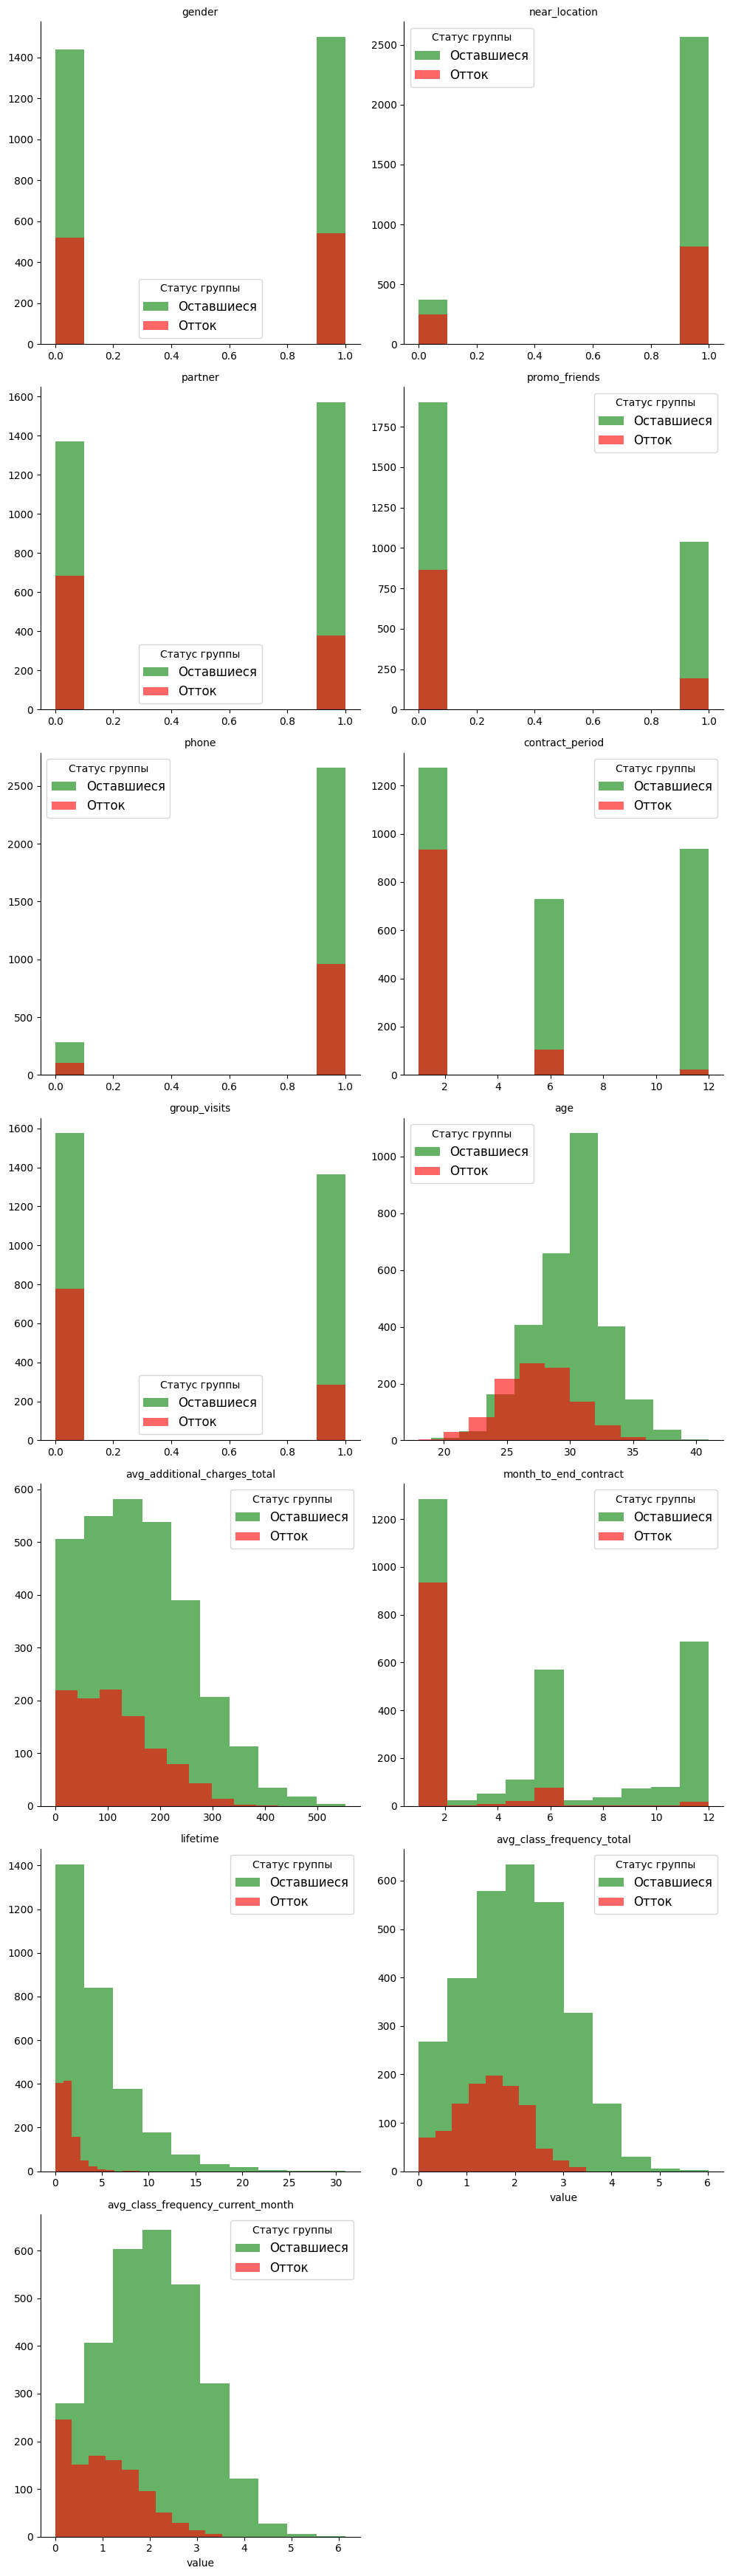

In [21]:
features_hist = sns.FacetGrid(df.melt(id_vars='churn'),
                  col='variable', hue='churn', sharex=False, sharey=False,
                  height=5, col_wrap=2, palette=['green','red'])
features_hist = features_hist.map(plt.hist, 'value', alpha=0.6)
features_hist.set_titles(col_template='{col_name}')
for ax in features_hist.axes.ravel():
    ax.legend(title='Статус группы', labels=['Оставшиеся', 'Отток'], prop={'size':12})

На ежемесячный отток **выраженно влияют** следующие признаки: `partner`, `promo_friends`, `lifetime`, `contract_period`, `month_to_end_contract`, `group_visits`, `avg_class_frequency_current_month`.

Также на отток погут влиять следующие признаки, но в очень легкой степени или при взаимосвязи с другими признаками: `near_Location`, `avg_class_frequency_total`, `avg_additional_charges_total`.

Стоит добавить, что пол никак не влияет на отток, а окончание абонемента говорит само за себя, тоже самое можно сказать и про возраст, если рассматривать средние или медианные значения. Однако, если делить клиентов на возрастные категории, то чаще всего больший отток по отношению к количеству клиентов в рамках данных возрастных групп приходится на клиентов в возрасте от 20 до примерно 26 лет.

### Матрица корреляций

Рассчитаем матрицу корреляций и на её основе построим тепловую карту.

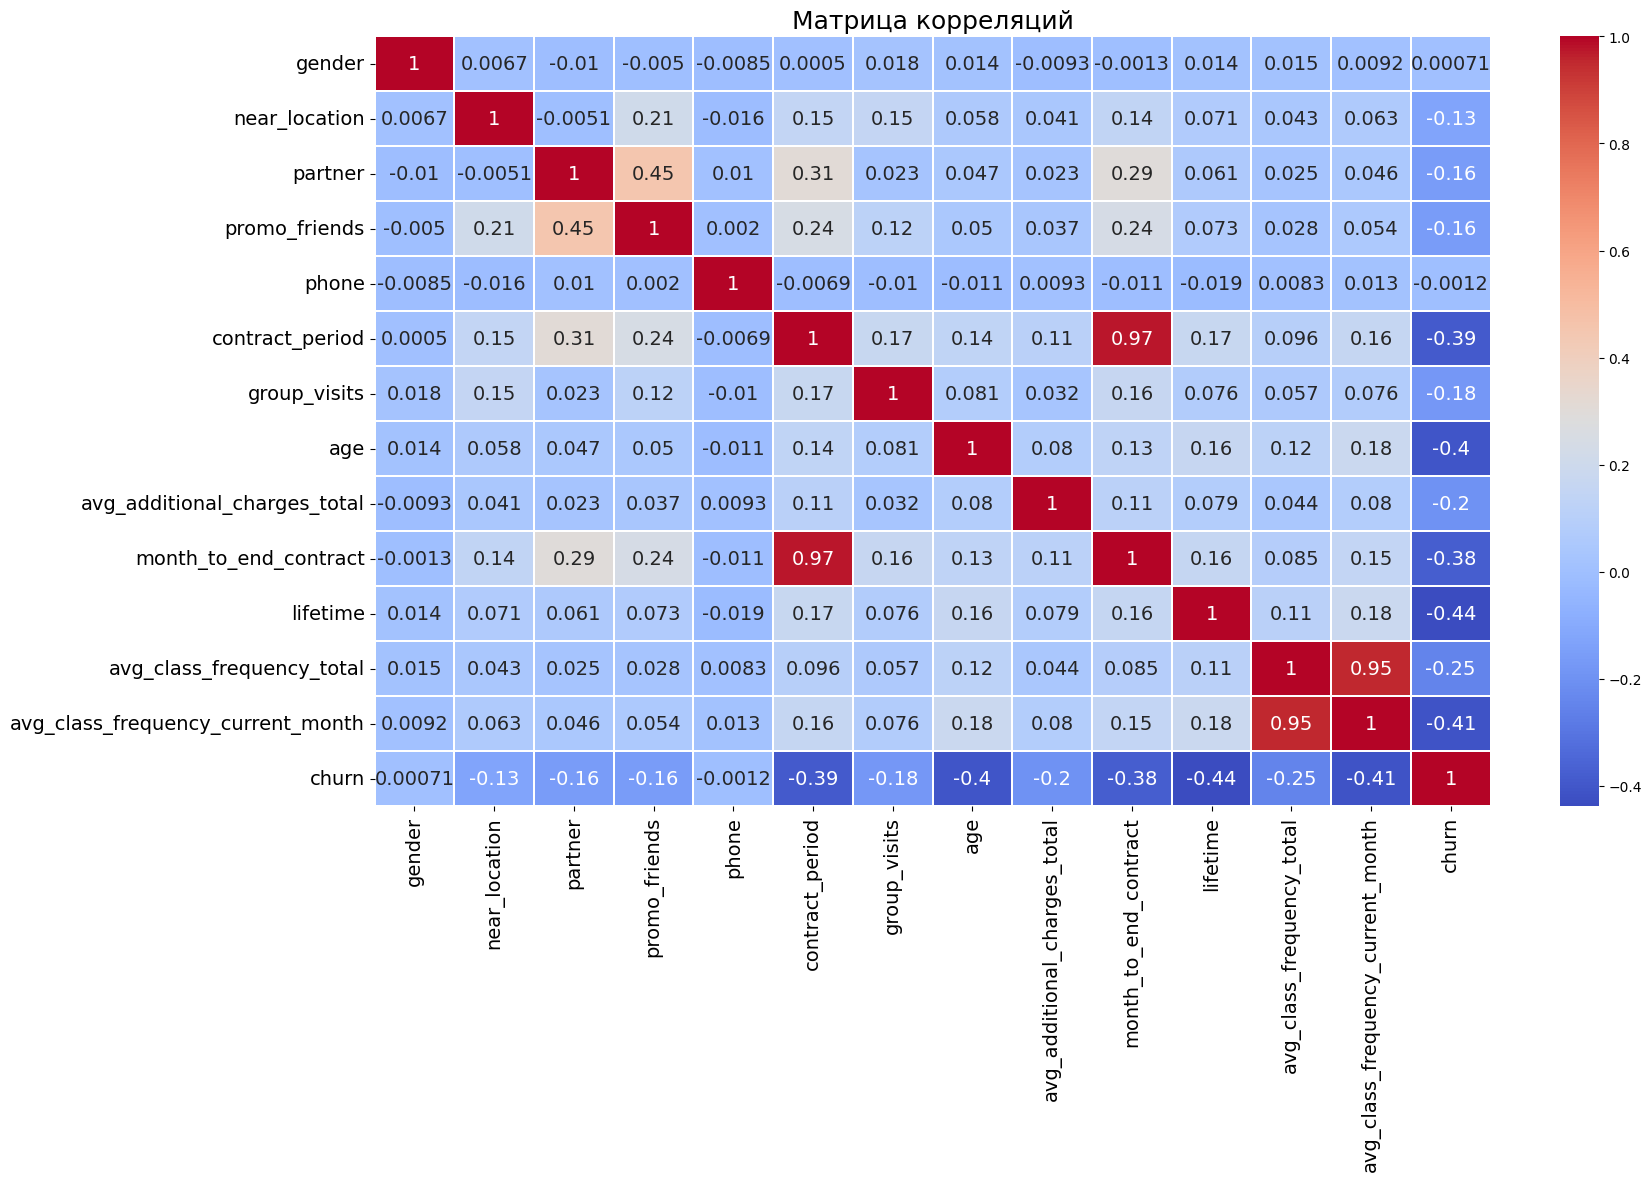

In [22]:
cm = df.corr()

sns.heatmap(cm, annot=True, square=False, cmap='coolwarm', linewidths=0.25,
            annot_kws={'fontsize':14})
plt.title('Матрица корреляций', fontsize = 18)
plt.xticks(rotation = 'vertical', fontsize = 14)
plt.yticks(rotation = 'horizontal', fontsize = 14)
plt.show()

Если рассмотреть тепловую карту, то можно увидеть, что многие наши предпроложения из шагов 2.6-2.8 подтвердились.

**Были выявлены мультиколлинеарные признаки:**

* `contract_period` — длительность текущего действующего абонемента коррелирует со сроком до окончания текущего действующего абонемента `month_to_end_contract` с коэффициентом **0.97**;
* `avg_class_frequency_total` — средняя частота посещения в неделю за все время с начала действия абонемента коррелирует со средней частотой посещений в неделю за предыдущий месяц `avg_class_frequency_current_month` с коэффициентом **0.95**;
* `partner` — сотрудник компании-партнёра клуба коррелирует с  фактом первоначальной записи в рамках акции «приведи друга» * `promo_friends` с коэффициентом **0.45**.

**Не оказывают влияния (коэффициент стремится к 0):**

* `gender` — пол;
* `phone` — наличие контактного телефона;

**Очень слабую обратную связь имеют следующие признаки:**

* `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах) (**-0.44**);
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц (**-0.41**);
* `age` —  возраст клиентов (**-0.4**)
* `contract_period` — средняя длительность текущего действующего абонемента пользователя (**-0.39**);
* `month_to_end_contract` — средний срок до окончания текущего действующего абонемента (**-0.38**);

Изначально можно подумать, что это важные признаки, но нашей целью является нахождение признаков, наиболее сильно влияющих на отток, а не признаки, которые могут увеличить приток новых клиентов или повысить продажи абонементов.

На всякий случай удалим мультиколлинеарные признаки, чтобы потом не возвращаться к этому шагу при выборе модели прогнозирования.

In [23]:
df.drop(['month_to_end_contract', 'avg_class_frequency_total'],
          axis=1, inplace=True)

### Вывод

Как выяснилось, нулевые значения, дубликаты и аномалииотсутсвуют.

Также  названия столбцов были приведены к "змеиному регистру" и к одному признаку был применен соответсвующий формат.

Если делить клиентов на возрастные категории, то отток по отношению к количеству клиентов в рамках данных возрастных групп приходится на клиентов в возрасте от 20 до примерно 26 лет.

Все признаки имеют обратную (отрицательную) корреляцию с целевой переменной.

Также мы избавились от двух мультиколлинеарных признаков.

На данный момент можно сказать, что в основном среди оставшихся клиентами являются сотрудники компаний-партнеров, друзья действующих клиентов, близ живующие люди и люди, которым почти 30 и более лет. Если собрать все перечисленные признаки воедино, то можно предположить, что чаще всего клиентами становятся люди, которые долго работают в компаниях-партнерах (либо занимающие должности, требующие многолетний опыт) и их друзья, пришедшии в рамках реферальной акции.

## Модель прогнозирования оттока пользователей

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Разбиение данных на выборки

Разделим данные на признаки (матрица X) и целевую переменную (y). В ваших данных нет временной структуры и наблюдения не складываются в последовательный временной ряд, поэтому  использование случайного разбиения с помощью параметра `stratify` методом `train_test_split()` вполне обосновано. Стоит отметить, что мы будем стратифицировать в соответствии распределению по классам в `y`.

In [24]:
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

Стандартизируем данные и обучим StandartScaler на обучающей выборке.

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Преобразуем обучающие и валидационные наборы данных.

In [26]:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели

Обучим модель на train-выборке двумя способами:
* логистической регрессией,
* случайным лесом.

Создадим список нужных нам моделей и зададим алгоритмы для каждой:

In [27]:
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(random_state=0),
]

Чтобы не писать код повторно для каждой модели - создадим соответсвующую функцию обучения моделей:

In [28]:
# функция 'predicting' имеет следующую конструкцию:
# принимает на вход название модели, модель и данные, выводит метрики accuracy, precision, recall,
# важности признаков и возвращает прогноз
def predicting(name_m, m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('Метрики для', name_m)

    # выведим метрики для полученного прогноза
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.3f}'.format(precision_score (y_test, y_pred)))
    print('Recall: {:.3f}\n'.format(recall_score(y_test, y_pred)))

### Оценка метрик

Применим ранее созданную функцию и выведем необходимые нам метрики:

In [29]:
predicting('логистической регрессии', models[0], X_train_st, y_train, X_test_st, y_test)
predicting('случайного леса', models[1], X_train_st, y_train, X_test_st, y_test)

Метрики для логистической регрессии
Accuracy: 0.917
Precision: 0.848
Recall: 0.840

Метрики для случайного леса
Accuracy: 0.905
Precision: 0.854
Recall: 0.774



* По параметру `Accuracy` (точность правильных ответов):

    Логистическая регрессия показывает себя немного лучше по сравнению со случайным лесом - 0,917 и 0,905 соответсвенно;


* По параметру `Precision` (точность верно распозннаных объектов):

    В целом обе модели одинаково определили объекты 1-го типа - 0,85, но модель случайного леса совсем чуть-чуть точнее;

* По параметру `Recall` (доля верно распозннаных объектов):

    Логистическая регрессия гораздо лучше справилась, и доля определения объектов 1-го типа по сравнению со случайным лесом - 0,84 против 0,774)


По всем метрикам логистическая регрессия дает результат немного лучше, чем случайный лес.

### Вывод

Обе модели показали вполне отличные результаты, но модель логистической регрессии чуть лучше по каждой из метрик по сравнению со случайным лесом.

## Кластеризация пользователей

Проведем обязательную стандартизацию данных перед работой с алгоритмами.

In [30]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Агломеративная иерархическая кластеризация

Передадим получившуюся стандартизированную таблицу в качестве параметра функции `linkage()`. С ее помощью построим матрицу расстояний, чтобы диаграмма получилась показательной, передадим параметру `method` значение `ward`, а послед  нарисуем дендрограмму.

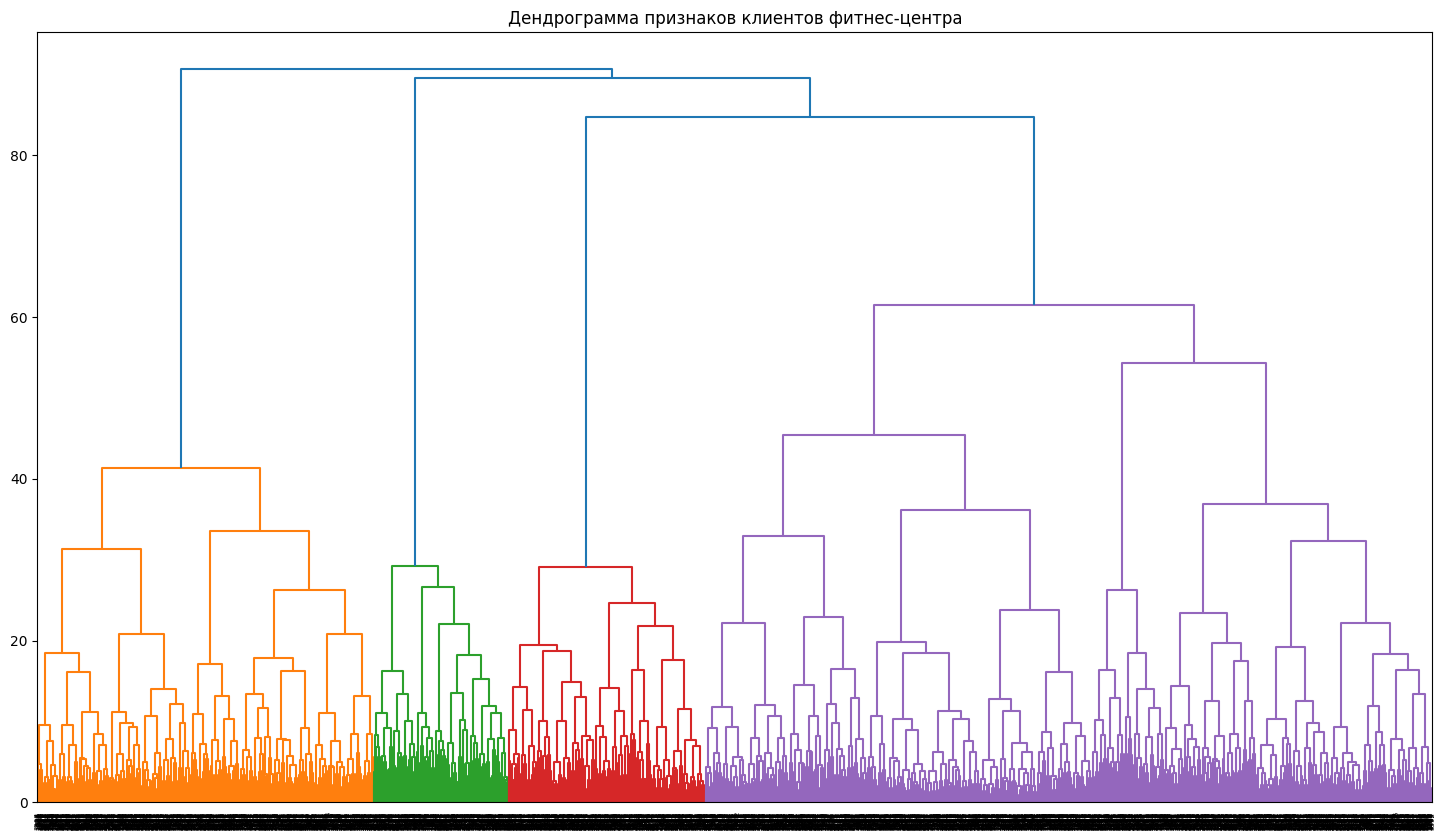

In [31]:
linked = linkage(X_sc, method = 'ward')
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков клиентов фитнес-центра')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цветов на графике, а так все зависит от поставленной задачи, т.к. кластеров может быть как на несколько больше, так и в разы.

### Прогноз кластеров клиентов

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [32]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0, n_init=10)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = km.fit_predict(X_sc)

In [33]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Значение метрики силуэта оказалось не очень высоким, поэтому назвать такую кластеризацию хорошей нельзя.

### Анализ средних значений признаков для кластеров

In [34]:
df.groupby('cluster_km').mean().T.style.background_gradient(cmap='coolwarm', axis=1).format(precision=2)

cluster_km,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


В среднем (при 100% обеспечении предложения) потеря прибыли составляет **15 710** долл., максимальные потери могут достигать **44 780** долл. в час.

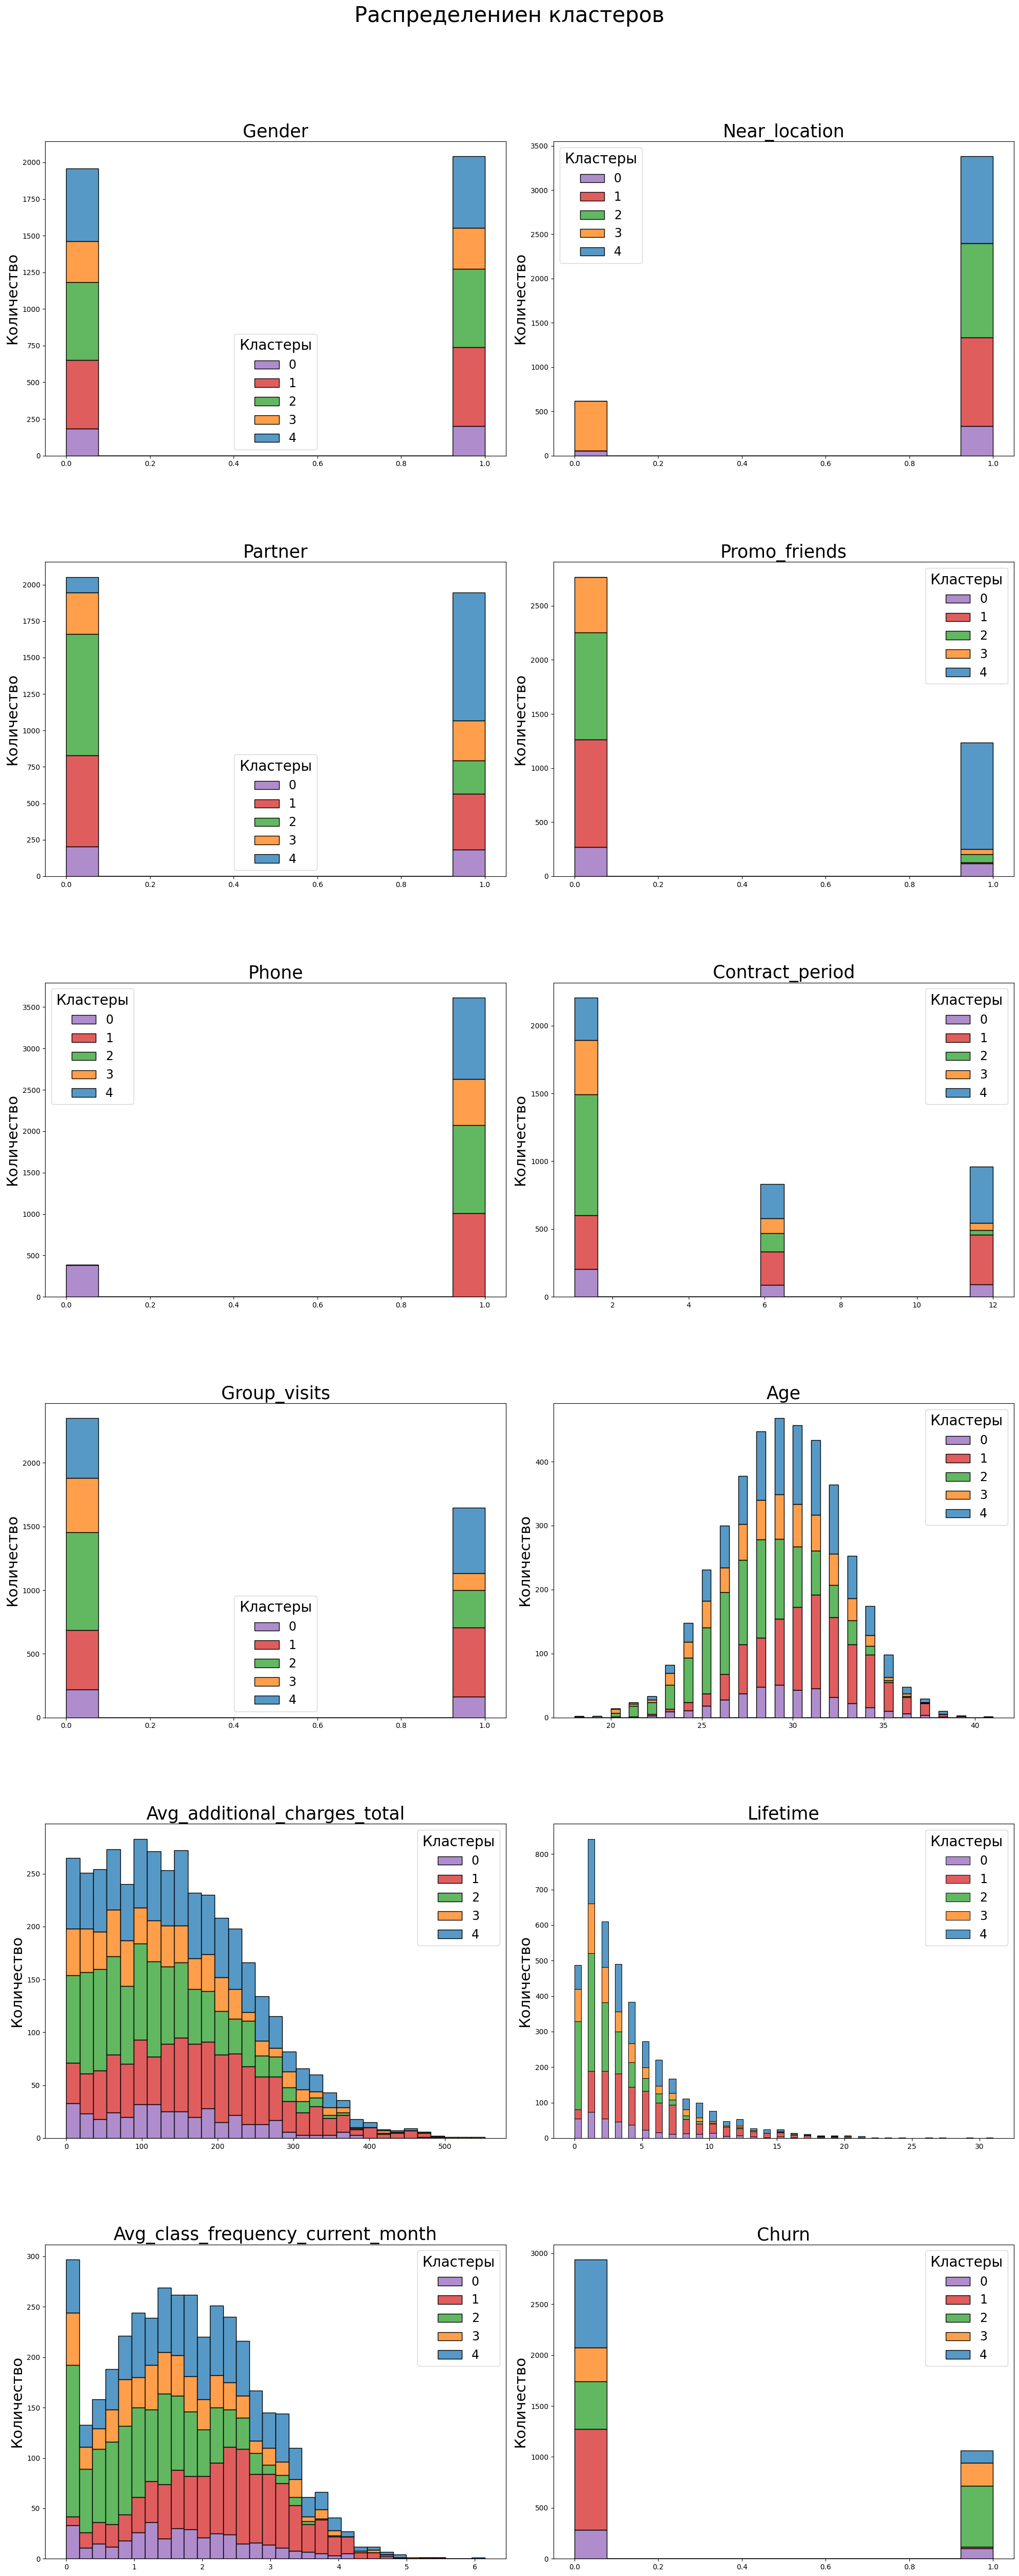

In [35]:
df_clusters = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.query('churn==1')['churn'].count()

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 50))
plt.subplots_adjust(hspace=10)
fig.suptitle('Распределениен кластеров', fontsize=30, y=1.005)
for column, ax in zip(df.drop(['cluster_km'], axis=1).columns, axs.ravel()):
    sns.histplot(df, x=column, hue='cluster_km', palette='tab10',
                 multiple='stack', ax=ax)
    ax.set_title(column.capitalize(), fontsize=25)
    ax.set_xlabel('')
    ax.set_ylabel('Количество', fontsize=21)
    ax.legend(title='Кластеры', title_fontsize = 20, fontsize=20, labels=df_clusters.index, prop={'size':17})
plt.tight_layout()
plt.show()

### Детальный анализ и характеристика кластеров

In [36]:
df_clusters = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.query('churn==1')['churn'].count()
fig = go.Figure(data=[go.Pie(labels=df_clusters.index, values=df_clusters.values, title='Доли оттока в кластерах')]);
fig.show()

Охарактеризуем каждый кластер:

**Кластер 0**
* Отток - 12% - **топ-2** среди оставшихся;
* Живут или работают недалеко от фитнес-центра;
* Большинство являются сотрудниками компании-партнёра клуба - **топ-1** по данному признаку;
* Все пришли по акции "приведи друга" - **топ-1** по данному признаку;
* Обладатели долгосрочных абонементов свыше 6 месяцев - **топ-1** по данному признаку;
* Чуть больше половины предпочитают групповые занятия - **топ-2** по данному признаку;
* В фитнес-центр ходят около 4 месяцев - **топ-2** по данному признаку;
* На дополнительные услуги тратят свыше 153 у.е. - **топ-2** по данному признаку;
* Средняя частота посещений в неделю за предыдущий месяц почти 2 раза в неделю - **топ-2** по данному признаку.

**Кластер 1**
* Отток - 40% - **топ-2** по данному признаку;
* Живут или работают далеко от фитнес-центра;
* 49% являются сотрудниками компании-партнёра клуба и те кто пришли по акции друзей - **топ-2** по данному признаку;
* В фитнес-центр ходят около 3 месяцев;
* На дополнительные услуги тратят свыше 137 у.е.

**Кластер 2**
* Отток - 56% - **топ-1** по данному признаку;
* Живут или работают недалеко от фитнес-центра;
* В фитнес-центр ходят около 2 месяцев - **меньше всех**;
* На дополнительные услуги тратят свыше 119 у.е. - **меньше всех**;
* Средняя частота посещений в неделю за предыдущий месяц около 1 раза в неделю - **меньше всех**.

**Кластер 3**
* Отток - 1% - **топ-1** среди оставшихся;
* Живут или работают недалеко от фитнес-центра;
* 38% являются сотрудниками компании-партнёра клуба - **топ-4** по данному признаку;
* Обладатели долгосрочных абонементов свыше 6 месяцев - **топ-2** по данному признаку;
* 54% предпочитают групповые занятия - **топ-1** по данному признаку;
* В фитнес-центр ходят более 5 месяцев - **топ-1** по данному признаку;
* На дополнительные услуги тратят свыше 176 у.е. - **топ-1** по данному признаку;
* Средняя частота посещений в неделю за предыдущий месяц более 2 раз в неделю - **топ-1** по данному признаку.

**Кластер 4**
* Отток - 27% - **топ-3** по данному признаку;
* 86% живут или работают недалеко от фитнес-центра;
* 47% являются сотрудниками компании-партнёра клуба - **топ-3** по данному признаку;
* 31% пришли по акции "приведи друга" - **топ-1** по данному признаку;
* Обладатели абонементов свыше 4 месяцев - **топ-3** по данному признаку;
* 43% предпочитают групповые занятия - **топ-3** по данному признаку;
* В фитнес-центр ходят около 4 месяцев - **топ-3** по данному признаку;
* На дополнительные услуги тратят свыше 144 у.е. - **топ-3** по данному признаку;
* Средняя частота посещений в неделю за предыдущий месяц почти 2 раза в неделю - **топ-3** по данному признаку.

### Распределение средних значений признаков для кластеров

### Вывод

Какие выводы по исследованию мы можем сделать?

Имеющиеся факты:
- Кластер 0 и 3 - самые благоприятные, т.к. имеют наименьший отток;
- Кластер 4 - нормальный, т.к. отток составляет почти четверть;
- Кластер 2 - самый плохой, т.к. имеет наибольший отток;
- Кластер 5 - плохой, т.к. больше половины клиентов уходят в отток;

Если аккумулировать признаки каждого кластера, то можно создать образ идеальной целевой аудитории, которая не уйдет в отток:
* Возрастприближается к 30 и более годам;
* Живут или работают недалеко от фитнес-центра;
* Являются сотрудниками компании-партнёра клуба или имеют друзей, которые поддерживают форму;
* Ходят на групповые занятия;
* Приобретают абонемент на 6 или 12 месяцев;
* Посещают фитнес-центр минимум 2 раза в неделю и около 10 раз в месяц.

К ред флагам стоит отнести:
* Молодой возраст (до 22-х лет);
* Проживание или работа в другом районе;
* Приобретают абонемент на 1 месяц;
* Хотя в фитнес-центр 1 раз в неделю, а в среднем менее 5 раз в месяц;

## Вывод

В данном исследовании мы данные по клиентам фитнес-центра за месячный период..

Перед тем как приступить к исследованию мы провели:

1. Предварительную обработку полученных данных - привели названия столбцов к нижнему регистру и типы данных, где это необходимо, провели проверку на пропущенные значения, дубликаты.
2. Была проведена проверка на аномальные значения и выбросы в данных.
3. Были удалены мульколлинеарные признаки.
4. Провели исследовательский анализ данных и подробно изучили признаки клиентов фитнес-центра.
5. Было обучено 2 модели прогнозирования оттока клиентов: логистической регрессией и случайным лесом.
6. Оценили метрики accuracy, precision и recall для обеих моделей на валидационной выборке
7. Проведена кластеризация клиентов с последующей их детальной характеристикой.

В ходе исследования было определено 5 кластеров:

**Кластер 0**
* Отток - 12% - **топ-2** среди оставшихся;
* Живут или работают недалеко от фитнес-центра;
* Большинство являются сотрудниками компании-партнёра клуба - **топ-1** по данному признаку;
* Все пришли по акции "приведи друга" - **топ-1** по данному признаку;
* Обладатели долгосрочных абонементов свыше 6 месяцев - **топ-1** по данному признаку;
* Чуть больше половины предпочитают групповые занятия - **топ-2** по данному признаку;
* В фитнес-центр ходят около 4 месяцев - **топ-2** по данному признаку;
* На дополнительные услуги тратят свыше 153 у.е. - **топ-2** по данному признаку;
* Средняя частота посещений в неделю за предыдущий месяц почти 2 раза в неделю - **топ-2** по данному признаку.

**Кластер 1**
* Отток - 40% - **топ-2** по данному признаку;
* Живут или работают далеко от фитнес-центра;
* 49% являются сотрудниками компании-партнёра клуба и те кто пришли по акции друзей - **топ-2** по данному признаку;
* В фитнес-центр ходят около 3 месяцев;
* На дополнительные услуги тратят свыше 137 у.е.

**Кластер 2**
* Отток - 56% - **топ-1** по данному признаку;
* Живут или работают недалеко от фитнес-центра;
* В фитнес-центр ходят около 2 месяцев - **меньше всех**;
* На дополнительные услуги тратят свыше 119 у.е. - **меньше всех**;
* Средняя частота посещений в неделю за предыдущий месяц около 1 раза в неделю - **меньше всех**.

**Кластер 3**
* Отток - 1% - **топ-1** среди оставшихся;
* Живут или работают недалеко от фитнес-центра;
* 38% являются сотрудниками компании-партнёра клуба - **топ-4** по данному признаку;
* Обладатели долгосрочных абонементов свыше 6 месяцев - **топ-2** по данному признаку;
* 54% предпочитают групповые занятия - **топ-1** по данному признаку;
* В фитнес-центр ходят более 5 месяцев - **топ-1** по данному признаку;
* На дополнительные услуги тратят свыше 176 у.е. - **топ-1** по данному признаку;
* Средняя частота посещений в неделю за предыдущий месяц более 2 раз в неделю - **топ-1** по данному признаку.

## Рекомендации

Исходя из этих тезисов в главе `4.6`, что в качестве радикальных мер стоит пересмотреть выбор геолокации при открытии новых фитнес-центров. Также стоит провести анализ каждого открытого клуба в отношении клиентов, т.к. важно знать какие кластеры в них преобладают, оценив их положение возможно стоит принять радикальные меры - закрыть некоторые клубы, открыв новые в местах, где охват может быть больше.

В качестве основных мер стимуляций со стороны маркетингового отдела можно сделать следующее:
1. Увеличить охват за счет наружной рекламы и рекламы в соц. сетях.
2. Наладить партнерские отношения с компания в определенном радиусе.
3. Добавить больше вариаций групповых занятий, либо обновить уже существующие программы - это повысит приобретение абонементов со стороны сотрудников компаний-партнеров, клиенты станут приводить друзей, а также поспособствует росту желания посещать фитнес-центры чаще как обычных клиентов, так и клиентов близких к оттоку.
4. Также стоит пересмотреть реферальную систему, т.к. она неплохо работает только среди клиентов, работающих в компаниях-партнерах.
5. Провести опрос среди молодых активных клиентов и тех, кто в оттоке, в возрасте до 25 лет. В качестве тем можно выбрать выбрать вопросы, связанные с низкой посещаемость и оттоком данной возрастной категории.